In [11]:

#Import libraries before starting
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels  # explicit top-level import to help resolvers
import statsmodels.api as sm
from matplotlib.lines import lineStyles

from statsmodels.regression.linear_model import OLS

# import both tests from the same module in one statement
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools
import yfinance as yf
import warnings
from joblib import Parallel, delayed
from arch import arch_model
from statsmodels.tools.sm_exceptions import ConvergenceWarning, EstimationWarning
import requests
from io import StringIO
import lxml
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=EstimationWarning)
warnings.filterwarnings("ignore")


In [12]:
%pip install arch 

In [13]:
tickers = ["BTC-USD","LTC-USD", "SOL-USD", "ETH-USD", "BNB-USD", "AVAX-USD"]
start_date = "2023-01-01"
end_date = "2025-12-31"
dataset = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)


dataset.head()

[*********************100%***********************]  6 of 6 completed


Price           Close                                                    \
Ticker       AVAX-USD     BNB-USD       BTC-USD      ETH-USD    LTC-USD   
Date                                                                      
2023-01-01  10.865915  244.136978  16625.080078  1200.964844  70.815659   
2023-01-02  11.153615  245.535904  16688.470703  1214.656616  74.862907   
2023-01-03  11.384450  246.133362  16679.857422  1214.778809  75.602722   
2023-01-04  12.077613  259.119690  16863.238281  1256.526611  75.433907   
2023-01-05  11.740196  256.422852  16836.736328  1250.438599  74.250809   

Price                       High                                         ...  \
Ticker        SOL-USD   AVAX-USD     BNB-USD       BTC-USD      ETH-USD  ...   
Date                                                                     ...   
2023-01-01   9.982173  10.929948  246.485809  16630.439453  1203.475342  ...   
2023-01-02  11.272967  11.231228  247.715271  16759.343750  1219.860596  ...   
2023-01-03  13.344046  11.528151  246.831451  16760.447266  1219.095337  ...   
2023-01-04  13.435113  12.270717  260.516052  16964.585938  1264.807495  ...   
2023-01-05  13.419330  12.149061  259.076477  16884.021484  1258.571533  ...   

Price               Open                                        Volume  \
Ticker           BTC-USD      ETH-USD    LTC-USD    SOL-USD   AVAX-USD   
Date                                                                     
2023-01-01  16547.914062  1196.713623  70.002823   9.961036   95741904   
2023-01-02  16625.509766  1201.103271  70.820496   9.983222  128530323   
2023-01-03  16688.847656  1214.744019  74.863411  11.274727  165410541   
2023-01-04  16680.205078  1214.718628  75.602333  13.351509  203700017   
2023-01-05  16863.472656  1256.484619  75.431168  13.434939  148011463   

Price                                                                  
Ticker        BNB-USD      BTC-USD     ETH-USD    LTC-USD     SOL-USD  
Date                                                                   
2023-01-01  278651737   9244361700  2399674550  344383885   194221164  
2023-01-02  357733262  12097775227  3765758498  699498243   558570124  
2023-01-03  377452410  13903079207  3392972131  562329324  1149255381  
2023-01-04  632924961  18421743322  6404416893  577893231  1142852070  
2023-01-05  342934041  13692758566  4001786456  432215597   564255825  

[5 rows x 30 columns]

In [14]:
#Getting returns
return_log = (np.log(dataset["Close"]) - np.log(dataset["Close"].shift(1))).dropna()
train_log = return_log.loc[:"2024-12-31", :]
test_log = return_log.loc["2025-01-01":, :]
train_log.columns, test_log.columns = tickers, tickers
test_log.tail()

,BTC-USD,LTC-USD,SOL-USD,ETH-USD,BNB-USD,AVAX-USD
Date,,,,,,
2025-11-24,0.045156,0.024827,0.016742,0.052507,0.029682,0.056998
2025-11-25,0.019889,-0.002679,-0.010576,0.001767,-0.002287,0.003749
2025-11-26,0.052675,0.033809,0.035723,0.023348,0.018453,0.029239
2025-11-27,0.005833,0.004259,0.008438,-0.004392,-0.002804,-0.015260
2025-11-28,0.002635,-0.003093,0.003991,0.015806,-0.009354,0.010092


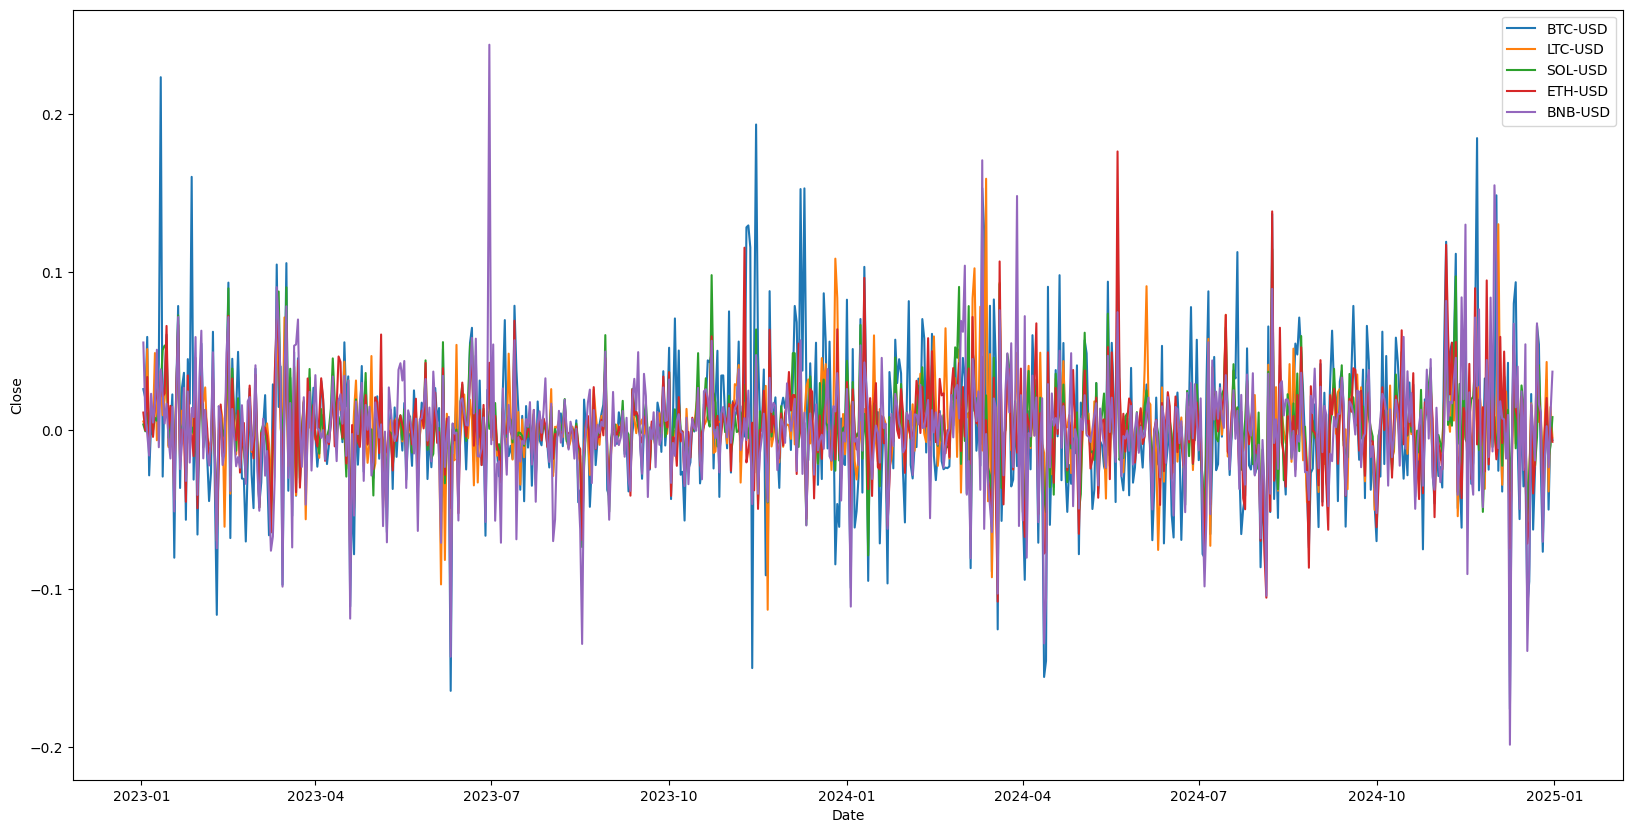

In [15]:
#Data visualization
plt.figure(figsize = (20, 10))
colors = ["blue", "green", "orange", "red", "pink"]
for ticker, col in zip(tickers, colors):
    plt.plot(train_log.index, train_log[ticker], label=ticker)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()

In [16]:

#ADF test
for ticker in tickers:
    print(f"<<<<<<<<<<<<<<<{ticker}>>>>>>>>>>>>>>>>")
    results_crypto = adfuller(train_log[ticker])
    print(f"Augmented Dickey-Fuller Test Results for: {ticker}")
    print(f"ADF Statistics: {results_crypto[0]:0.4f}")
    if results_crypto[1] >= 0.05:
        print(f"p-Values: {results_crypto[1]:0.4f}")
        print("Time series  is non stationary")
    else:
        print("Time series is stationary")
    print("Critical Values:")
    for key, value in results_crypto[4].items():
        print(f" {key}: {value:0.2f}")


<<<<<<<<<<<<<<<BTC-USD>>>>>>>>>>>>>>>>
Augmented Dickey-Fuller Test Results for: BTC-USD
ADF Statistics: -26.2743
Time series is stationary
Critical Values:
 1%: -3.44
 5%: -2.87
 10%: -2.57
<<<<<<<<<<<<<<<LTC-USD>>>>>>>>>>>>>>>>
Augmented Dickey-Fuller Test Results for: LTC-USD
ADF Statistics: -28.1411
Time series is stationary
Critical Values:
 1%: -3.44
 5%: -2.87
 10%: -2.57
<<<<<<<<<<<<<<<SOL-USD>>>>>>>>>>>>>>>>
Augmented Dickey-Fuller Test Results for: SOL-USD
ADF Statistics: -18.1288
Time series is stationary
Critical Values:
 1%: -3.44
 5%: -2.87
 10%: -2.57
<<<<<<<<<<<<<<<ETH-USD>>>>>>>>>>>>>>>>
Augmented Dickey-Fuller Test Results for: ETH-USD
ADF Statistics: -27.9825
Time series is stationary
Critical Values:
 1%: -3.44
 5%: -2.87
 10%: -2.57
<<<<<<<<<<<<<<<BNB-USD>>>>>>>>>>>>>>>>
Augmented Dickey-Fuller Test Results for: BNB-USD
ADF Statistics: -9.4941
Time series is stationary
Critical Values:
 1%: -3.44
 5%: -2.87
 10%: -2.57
<<<<<<<<<<<<<<<AVAX-USD>>>>>>>>>>>>>>>>
Augmen

In [18]:


def fit_varmax(train_log, p, q):
    """Fit a single VARMAX model and return results."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = VARMAX(train_log, order=(p, q), 
                          enforce_stationarity=False, 
                          enforce_invertibility=False)
            fitted = model.fit(method='lbfgs', maxiter=300, disp=False)
            return (p, q, fitted.aic, fitted)
    except Exception as e:
        return (p, q, np.inf, None)

# Parallel grid search (uses all CPU cores)
print("Fitting models in parallel...")
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(fit_varmax)(train_log, p, q) 
    for p in range(1, 6) 
    for q in range(1, 6)
)

# Find best model
best_result = min(results, key=lambda x: x[2])
best_order = (best_result[0], best_result[1])
best_ic = best_result[2]
best_model = best_result[3]

print(f"\nBest order: {best_order}")
print(f"Best AIC: {best_ic:.4f}")

# Optional: Show top 5 models
print("\nTop 5 models:")
sorted_results = sorted(results, key=lambda x: x[2])[:5]
for p, q, aic, _ in sorted_results:
    print(f"  Order ({p}, {q}): AIC = {aic:.4f}")

Fitting models in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 40.3min



Best order: (1, 1)
Best AIC: -19795.7292

Top 5 models:
  Order (1, 1): AIC = -19795.7292
  Order (2, 1): AIC = -19770.3783
  Order (1, 2): AIC = -19765.4289
  Order (3, 1): AIC = -19742.7611
  Order (1, 3): AIC = -19742.6317


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 53.6min finished


In [ ]:
parameters = [ (p, q) for p, q in list(itertools.product(range(1,6), repeat=2)) if (p ==1 and q >=1) or (p>=1 and q==1)]
print(parameters)
def fitted_varmax(p, q):
    model = VARMAX(train_log, order=(p, q), measurement_error=False)
    fitted = model.fit(method="powell", maxiter=200)
    return p, q, fitted.aic
result = Parallel(n_jobs=-1)(delayed(fitted_varmax)(p,q) for p, q in parameters)
print(result)
#Selectiing the best model
def best_model(result):

        min_aic = result[0][2]
        aic_index = 0


        for i in range(1,len(result)):

            if result[aic_index][2] < min_aic:
                min_aic = result[aic_index][2]
                aic_index = i
        return aic_index


In [ ]:
import pandas as pd 
df = pd.read_csv("gradient_decent.csv")
df.head()

